In [1]:
from tifffile import imread
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import skimage
import pandas as pd
import csv
from scipy import stats

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

%run utils.ipynb

# Max Projection to Merge bundle image to Neurons

In [158]:
root="/Users/eminhanozil/Yanik Lab Dropbox/Eminhan Özil/Localization Manuscript 2024/RAT DATA/rEO_10/histology/4x-Tiff"

filenames = [f.split("- C=")[0] for f in os.listdir(root) if os.path.isfile(os.path.join(root, f))]


In [159]:
# Crisp Blue: RGB(0, 121, 184)
# Vibrant Orange: RGB(255, 87, 34)
# Bright Green: RGB(76, 175, 80)
# Rich Purple: RGB(156, 39, 176)

colorpalette =[[0, 121, 184],
                [255, 87, 34],
                [76, 175, 80],
                [156, 39, 176]
                ]

In [162]:
np.unique(filenames)

array(['_rEOZ010_s4_n1_4x_C561, C488, C640_20250224_01.vsi - _rEOZ010_s4_n1_4x_C561, C488, C640_20250224_01.vsi #3 ',
       '_rEOZ010_s4_n2_4x_C561, C488, C640_20250224_01.vsi - _rEOZ010_s4_n2_4x_C561, C488, C640_20250224_01.vsi #3 ',
       '_rEOZ010_s4_n3_4x_C561, C488, C640_20250224_01.vsi - _rEOZ010_s4_n3_4x_C561, C488, C640_20250224_01.vsi #3 '],
      dtype='<U107')

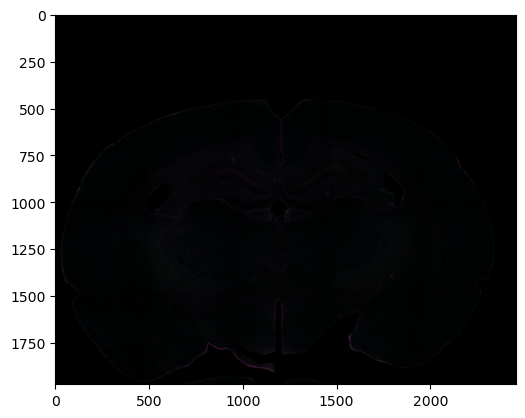

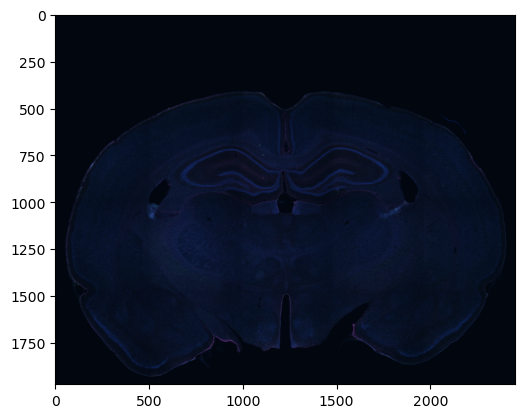

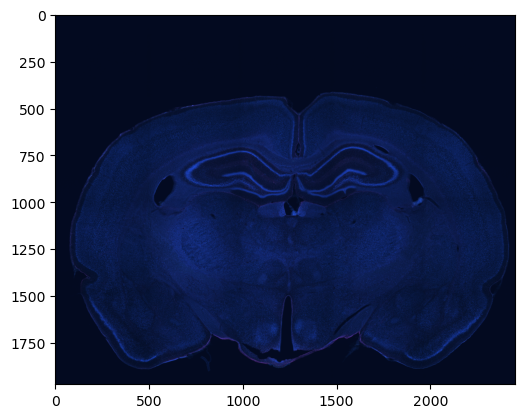

In [169]:
for f in np.unique(filenames):
    if f != '.DS_Store':
        for c in range(3):
            filename = f + "- C=" + str(c) + ".tif"
            if c==0:
                img = imread(os.path.join(root, filename))
                img = np.max(img , axis=0)
                img = ((img - np.min(img))/(np.max(img)-np.min(img)) * 255).astype('uint16')            
                imgRGB = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
                r,g,b= colorpalette[c+1]
                
                imgRGB[:,:,0]=imgRGB[:,:,0]*b/255
                imgRGB[:,:,1]=imgRGB[:,:,1]*g/255
                imgRGB[:,:,2]=imgRGB[:,:,2]*r/255
                # imgRGB[:,:,3]=imgRGB[:,:,3]*a/255
                
            else:
                imgTmp = imread(os.path.join(root, filename))
                imgTmp = np.max(imgTmp , axis=0)
                imgTmp = ((imgTmp - np.min(imgTmp))/(np.max(imgTmp)-np.min(imgTmp)) * 255).astype('uint16')            
                imgRGBTmp = cv2.cvtColor(imgTmp, cv2.COLOR_GRAY2RGB)
                r,g,b= colorpalette[c+1]
                
                imgRGBTmp[:,:,0]=imgRGBTmp[:,:,0]*b/255
                imgRGBTmp[:,:,1]=imgRGBTmp[:,:,1]*g/255
                imgRGBTmp[:,:,2]=imgRGBTmp[:,:,2]*r/255
                # imgRGBTmp[:,:,3]=imgRGBTmp[:,:,3]*a/255
                
                imgRGB = imgRGB + imgRGBTmp

        # imgRGB = imgRGB + imgRGBTmp
        imgRGB = ((imgRGB - np.min(imgRGB))/(np.max(imgRGB)-np.min(imgRGB)) * 255).astype('uint8')
        plt.imshow(imgRGB)
        plt.show()
        filename = f + "z-Max.tiff"
        cv2.imwrite(os.path.join(root, "z-Max", filename), imgRGB)

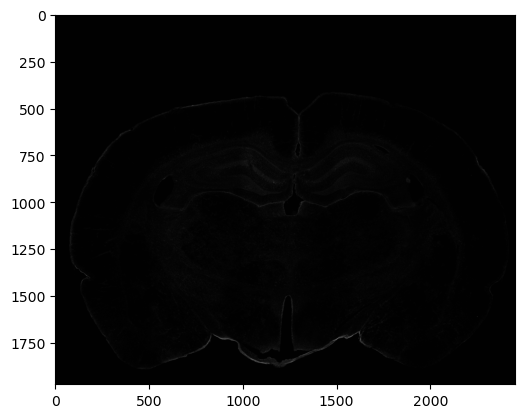

In [168]:
plt.imshow(imgTmp, cmap='gray')

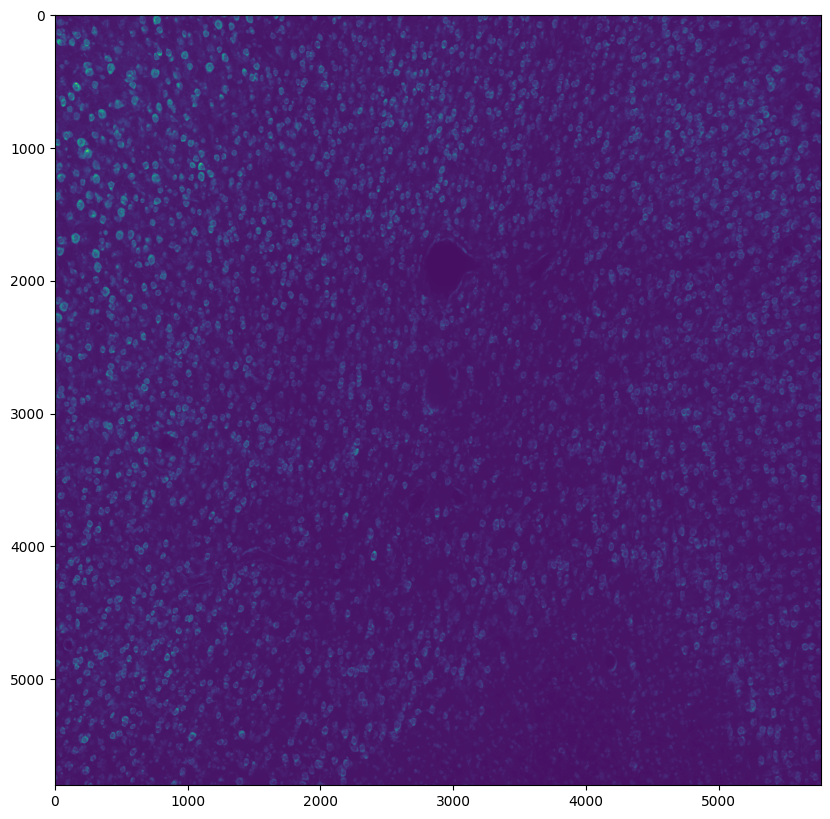

In [185]:
# filename="_rEO008_s06_n3_20x_spot4_nissl-stack.tif"

nissl_data = imread(os.path.join(root, filename))
nissl_data=np.moveaxis(nissl_data, 0, -1)
plt.figure(figsize=(10,10))
plt.imshow(nissl_data[12,:,:])

In [272]:
electrodesMaxProj=np.max(nissl_data[1:4,:,:], axis=0)
# electrodesMaxProj8Bit = (electrodesMaxProj/256).astype('uint8')
electrodesMaxProjRGBA = cv2.cvtColor(electrodesMaxProj, cv2.COLOR_GRAY2RGB)
electrodesMaxProjRGBA[:,:,0]=electrodesMaxProjRGBA[:,:,0]
electrodesMaxProjRGBA[:,:,1]=electrodesMaxProjRGBA[:,:,1]
electrodesMaxProjRGBA[:,:,2]=electrodesMaxProjRGBA[:,:,2]*30
# electrodesMaxProjRGBA[:,:,3]=(electrodesMaxProj>300)*electrodesMaxProjRGBA[:,:,3]
# cv2.imwrite(os.path.join(root, "imwrite_test.tiff"), electrodesMaxProjRGBA)

In [97]:
neuronsMaxProjRGBA = cv2.cvtColor(neuronsMaxProj, cv2.COLOR_GRAY2RGB)
neuronsMaxProjRGBA[:,:,0]=neuronsMaxProjRGBA[:,:,0]*28.55
neuronsMaxProjRGBA[:,:,1]=neuronsMaxProjRGBA[:,:,1]
neuronsMaxProjRGBA[:,:,2]=neuronsMaxProjRGBA[:,:,2]
# neuronsMaxProjRGBA[:,:,3]=(electrodesMaxProj>300)*electrodesMaxProjRGBA[:,:,3]
# cv2.imwrite(os.path.join(root, "neurons_maxProj.tiff"), neuronsMaxProjRGBA)

In [98]:
mergedRGB=electrodesMaxProjRGBA+neuronsMaxProjRGBA
cv2.imwrite(os.path.join(root, "merged_maxProj.tiff"), mergedRGB)

In [251]:
root="/Users/eminhanozil/Dropbox (Yanik Lab)/Localization Manuscript 2024/RAT DATA"
animal_id="rEO_08"
spot="s06_n3_20x_spot4"
workingdir=os.path.join(root, animal_id, "histology", spot)

# Fluorescence Intensity Analysis

In [2]:
hddroot="/Volumes/LaCie/data/rEO_08/histology"
centers_filename="electrode-centers.csv"
path=os.path.join(hddroot, centers_filename)
metadatadf=read_metadata(path)

In [4]:
def gen_contours(data, center, r_base, r_um, limit_um=None):
    """
    Generate a mask image with circular equi-distance contours centered to predefined electrode center
    data: histology images zStacked. x_pxl x y_pxl x img_planes
    center: predefined center point for the electrodes, [x, y]
    r: radius of contours in micrometers
    """
    r=np.round(r_um/0.325).astype(int)
    r_base_px = np.round(r_base/0.325).astype(int)
    cx,cy = center
    mask=np.ones_like(data[:,:,0])
    num_regions=int(limit_um/r_um)
    
    if r_base_px:
        roi=skimage.morphology.disk(r_base_px)        
        mask[cx-r_base_px:cx+r_base_px+1, cy-r_base_px:cy+r_base_px+1]=mask[cx-r_base_px:cx+r_base_px+1, cy-r_base_px:cy+r_base_px+1]+roi
            
    for i in range(1,num_regions+1):
        rTmp = r*i + r_base_px
        roi=skimage.morphology.disk(rTmp)        
        mask[cx-rTmp:cx+rTmp+1, cy-rTmp:cy+rTmp+1]=mask[cx-rTmp:cx+rTmp+1, cy-rTmp:cy+rTmp+1]+roi

    if r_base:
        mask[mask==num_regions+2]=0
    # else:
    #     mask=i-mask+1
        
    return num_regions, mask

In [5]:
def mask_vessels(mask, v_x, v_y, v_r):
    roi=skimage.morphology.disk(v_r)*999
    mask[v_x-v_r:v_x+v_r+1, v_y-v_r:v_y+v_r+1]=mask[v_x-v_r:v_x+v_r+1, v_y-v_r:v_y+v_r+1]+roi
    # mask=mask*(mask>0)
    return mask

In [6]:
def gen_control_area(mask, r_base, r_um, limit_um, control_location, offset=0):
    r=np.round(r_um/0.325).astype(int)
    r_base_px = np.round(r_base/0.325).astype(int)
    limit=np.round(limit_um/0.325).astype(int)
    offset = np.round(offset/0.325).astype(int)
    num_regions=int(limit_um/r_um)

    if offset:
        limit=offset
    
    if control_location==1:
        cx=limit+r_base_px+2 
        cy=limit+r_base_px+2 
        
    elif control_location==2:
        cx=limit+r_base_px+2 
        cy=np.shape(mask)[1]-limit-r_base_px-2 

    elif control_location==3:
        cx=np.shape(mask)[0]-limit-r_base_px-2 
        cy=limit+r_base_px+2 
        
    elif control_location==4:
        cx=np.shape(mask)[0]-limit-r_base_px-2 
        cy=np.shape(mask)[1]-limit-r_base_px-2

    # cx=limit+r_base_px+2 
    # cy=limit+r_base_px+2 
    # if r_base:
    #     roi=skimage.morphology.disk(r_base_px)*10       
    #     mask[cx-r_base_px:cx+r_base_px+1, cy-r_base_px:cy+r_base_px+1]=mask[cx-r_base_px:cx+r_base_px+1, cy-r_base_px:cy+r_base_px+1]+roi            
    # for i in range(1,num_regions+1):
    #     rTmp = r*i + r_base_px
    #     roi=skimage.morphology.disk(rTmp)*10        
    #     mask[cx-rTmp:cx+rTmp+1, cy-rTmp:cy+rTmp+1]=mask[cx-rTmp:cx+rTmp+1, cy-rTmp:cy+rTmp+1]+roi

    # cx=limit+r_base_px+2 
    # cy=np.shape(mask)[1]-limit-r_base_px-2 
    # if r_base:
    #     roi=skimage.morphology.disk(r_base_px)*10       
    #     mask[cx-r_base_px:cx+r_base_px+1, cy-r_base_px:cy+r_base_px+1]=mask[cx-r_base_px:cx+r_base_px+1, cy-r_base_px:cy+r_base_px+1]+roi       
    # for i in range(1,num_regions+1):
    #     rTmp = r*i + r_base_px
    #     roi=skimage.morphology.disk(rTmp)*10        
    #     mask[cx-rTmp:cx+rTmp+1, cy-rTmp:cy+rTmp+1]=mask[cx-rTmp:cx+rTmp+1, cy-rTmp:cy+rTmp+1]+roi

    # cx=np.shape(mask)[0]-limit-r_base_px-2 
    # cy=limit+r_base_px+2
    # if r_base:
    #     roi=skimage.morphology.disk(r_base_px)*10       
    #     mask[cx-r_base_px:cx+r_base_px+1, cy-r_base_px:cy+r_base_px+1]=mask[cx-r_base_px:cx+r_base_px+1, cy-r_base_px:cy+r_base_px+1]+roi       
    # for i in range(1,num_regions+1):
    #     rTmp = r*i + r_base_px
    #     roi=skimage.morphology.disk(rTmp)*10        
    #     mask[cx-rTmp:cx+rTmp+1, cy-rTmp:cy+rTmp+1]=mask[cx-rTmp:cx+rTmp+1, cy-rTmp:cy+rTmp+1]+roi

    # cx=np.shape(mask)[0]-limit-r_base_px-2 
    # cy=np.shape(mask)[1]-limit-r_base_px-2
    if r_base:
        roi=skimage.morphology.disk(r_base_px)*10       
        mask[cx-r_base_px:cx+r_base_px+1, cy-r_base_px:cy+r_base_px+1]=mask[cx-r_base_px:cx+r_base_px+1, cy-r_base_px:cy+r_base_px+1]+roi       
    for i in range(1,num_regions+1):
        rTmp = r*i + r_base_px
        roi=skimage.morphology.disk(rTmp)*10        
        mask[cx-rTmp:cx+rTmp+1, cy-rTmp:cy+rTmp+1]=mask[cx-rTmp:cx+rTmp+1, cy-rTmp:cy+rTmp+1]+roi

    
    mask[mask==10*(num_regions+1)+1]=0
    
    return mask

In [89]:
def mask_stitches(mask):
    mask[1925:2050, :] = 0
    mask[3850:3950, :] = 0
    mask[:, 1900:2000] = 0
    mask[:, 3800:3900] = 0
    return mask

In [77]:
def set_reference(mask):
    width = 1500
    tmpMask = mask
    onesMask = (mask == 1).astype(int)
    
    onesMask[width:-width,width:-width] = onesMask[width:-width,width:-width]* -1
    onesMask[onesMask==1] = 0
    mask = mask + onesMask 
    
    return mask

In [86]:
def get_means(metadatadf, staining, r_contour, limit):
    tifroot="/Volumes/LaCie/data/rEO_08/histology/20x-tiffs"
    # zoffset=2
    control_locations = [1,2,3,4]
    pooled_means=[]
    normed_means=np.array([])
    allmeans=[]
    for filename in metadatadf['filename']:
        exclude = metadatadf['exclude'].loc[metadatadf['filename']==filename].values[0]
        if not exclude:
            print(filename)
            cx = metadatadf['center_x'].loc[metadatadf['filename']==filename].values[0]
            cy = metadatadf['center_y'].loc[metadatadf['filename']==filename].values[0]
            v_x = metadatadf['v_x'].loc[metadatadf['filename']==filename].values[0]
            v_y = metadatadf['v_y'].loc[metadatadf['filename']==filename].values[0]
            v_r = np.round(metadatadf['v_r'].loc[metadatadf['filename']==filename].values[0]/0.325*1.5).astype(int)
            
            r_base = metadatadf['r_base'].loc[metadatadf['filename']==filename].values[0]
            r_base = r_base + 10
            
            z_start = metadatadf['plane_start'].loc[metadatadf['filename']==filename].values[0]
            z_stop = metadatadf['plane_stop'].loc[metadatadf['filename']==filename].values[0]
            plane_selected = metadatadf['plane_selected'].loc[metadatadf['filename']==filename].values[0]
            
            control_location = metadatadf['control_location'].loc[metadatadf['filename']==filename].values[0]
            filename=filename+"_"+staining+".tif"
            data = imread(os.path.join(tifroot, filename))
            data=np.moveaxis(data, 0, -1)
            if not plane_selected:
                z_start=9
                z_stop=12
                dataMaxProj = np.max(data[:,:,z_start:z_stop], axis=2)
            else:
                dataMaxProj = np.max(data[:,:,plane_selected:plane_selected+3], axis=2)
            
            # for control_location in range(1,5):                
            num_regions, mask=gen_contours(data, [cx, cy], r_base, r_contour, limit_um=limit)
            mask=gen_control_area(mask, r_base, r_contour, limit_um=limit, control_location=control_location)
            mask = set_reference(mask)
            
            mask[mask==65535] = 0
            zmid = np.round((z_start+z_stop)/2).astype(int)
            if v_r:
                mask=mask_vessels(mask, v_x, v_y, v_r)
            mask = mask_stitches(mask)
            fig, (ax1, ax2) = plt.subplots(1, 2)
            ax1.imshow(dataMaxProj, cmap='gray')
            ax2.imshow(mask, cmap='jet')
            plt.show()
            
            
            
                
            props=skimage.measure.regionprops_table(mask, dataMaxProj, properties=('label', 'area', 'intensity_mean', 'intensity_std'),)
            df=pd.DataFrame(props)
            mean_columns=[column for column in df.columns.values if "intensity_mean" in column]
            df["pooled norm mean"]=(df[mean_columns]/df[mean_columns].loc[0]).mean(axis=1)
            # allmeans.append((df[mean_columns]/df[mean_columns].loc[0]).values)
            print(df)
            pooled_means.append(df["pooled norm mean"].values[:2*num_regions+1])
            print(np.mean(df["pooled norm mean"].values[num_regions+1:2*num_regions+1]))    
    pooled_means=np.array(pooled_means)

    return pooled_means, allmeans

In [90]:
hddroot="/Volumes/LaCie/data/rEO_08/histology"
centers_filename="electrode-centers.csv"
path=os.path.join(hddroot, centers_filename)
metadatadf=read_metadata(path)
metadatadf

filename  center_x  center_y   v_x   v_y  v_r  \
0   _rEO008_s03_n1_20x_spot1_zStack      2936      2840     0     0    0   
1   _rEO008_s03_n1_20x_spot2_zStack      2980      2864  1310  2605   25   
2          _rEO008_s03_n2_spot1_20x      2920      2824     0     0    0   
3          _rEO008_s03_n2_spot2_20x      2960      2816     0     0    0   
4          _rEO008_s03_n3_spot4_20x      3000      2888  1735  3185   70   
5          _rEO008_s04_n1_spot4_20x      3010      2890  1695  3110   60   
6   _rEO008_s04_n2_20x_spot4_zStack      2990      2835  1655  3085   55   
7          _rEO008_s04_n3_spot3_20x      2810      2950     0     0    0   
8   _rEO008_s05_n1_20x_spot4_zStack      2985      2765  1675  3075   55   
9   _rEO008_s05_n2_20x_spot4_zStack      2995      2860  1700  3125   55   
10  _rEO008_s05_n3_20x_spot4_zStack      2825      2800  1580  3000   60   
11         _rEO008_s06_n1_spot4_20x      2900      2825  1695  2960   65   
12         _rEO008_s06_n2_spot4_20x      2915      2875  1900  2890   65   
13  _rEO008_s06_n3_20x_spot4_zStack      2800      2890  1845  2945   65   
14         _rEO008_s11_n1_spot1_20x      3000      2830     0     0    0   
15         _rEO008_s11_n1_spot2_20x      2980      2875     0     0    0   
16         _rEO008_s11_n2_spot1_20x      2940      2750  3290  1835   65   
17         _rEO008_s11_n2_spot2_20x      2925      2850     0     0    0   
18         _rEO008_s11_n3_spot1_20x      2980      2875  3050  2020   70   
19         _rEO008_s11_n3_spot2_20x      2950      2890     0     0    0   
20         _rEO008_s12_n1_spot1_20x      2990      2820  2855  2070   70   
21         _rEO008_s12_n1_spot2_20x      3100      2900     0     0    0   
22         _rEO008_s12_n2_spot1_20x      2990      2785  2600  2100   75   
23         _rEO008_s12_n2_spot2_20x      3000      2800  4720  2790   90   
24         _rEO008_s12_n3_spot1_20x      2940      2850  2195  2315  100   
25         _rEO008_s12_n3_spot2_20x      2950      2945  4465  2675   90   
26         _rEO008_s13_n1_spot1_20x      2975      2850  1925  2430   80   
27         _rEO008_s13_n1_spot2_20x      2985      2840  4340  2420   80   

    plane_start  plane_stop  plane_selected  exclude  r_base  control_location  
0             5           8               0        0      40                 2  
1             7          10               8        0      40                 3  
2             0           0               0        1      40                 3  
3             5           8               0        0      40                 1  
4            12          15              12        0      40                 2  
5             5          15               8        0      35                 4  
6             5          16               0        0      35                 2  
7             0           0               0        1      50                 2  
8             7          17               0        0      35                 4  
9             7          15               0        0      30                 2  
10            7          16               0        0      30                 3  
11            7          16               0        1      40                 3  
12            6          16               7        1      40                 1  
13            6           8               7        1      45                 3  
14            0           0               0        1      20                 3  
15            0           0               0        1      20                 2  
16            6          16               0        1      20                 3  
17            0           0               0        1      20                 3  
18            6          16               0        1      20                 4  
19            0           0               0        1      20                 3  
20            4          14               0        1      20                 3  
21            5          15             

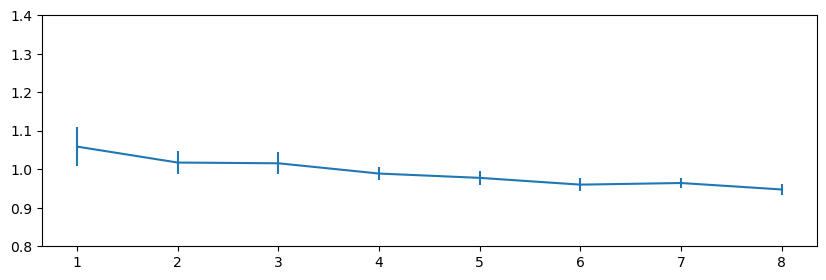

In [101]:
electrode = np.flip(gfap_pooled_means[:, 1:num_regions+1])
control = np.flip(gfap_pooled_means[:, num_regions+1:])
plt.figure(figsize=(10,3))
plt.errorbar(np.linspace(1,num_regions,num_regions), np.mean(electrode, axis=0), np.std(electrode, axis=0)/np.sqrt(num_regions))
# plt.errorbar(np.linspace(1,num_regions,num_regions), np.mean(control, axis=0), np.std(control, axis=0)/np.sqrt(num_regions))
# plt.hlines(1, 1, 10)
plt.ylim([0.8,1.4])
root="/Users/eminhanozil/Dropbox (Yanik Lab)/Localization Manuscript 2024/FIGURE_5-STABILITY"
filename="iba-electrode-r40-reach320.pdf"
plt.savefig(os.path.join(root, filename))

In [18]:
root="/Users/eminhanozil/Dropbox (Yanik Lab)/Localization Manuscript 2024/FIGURE_5-STABILITY"
filename = "iba-electrode-r40-reach320.npy"
nissl=np.load(os.path.join(root, filename))

In [20]:
np.std(nissl, axis=0)

array([0.14134226, 0.08764295, 0.08114311, 0.04518001, 0.05074593,
       0.04631778, 0.03503208, 0.0431494 ])

_rEO008_s03_n1_20x_spot1_zStack


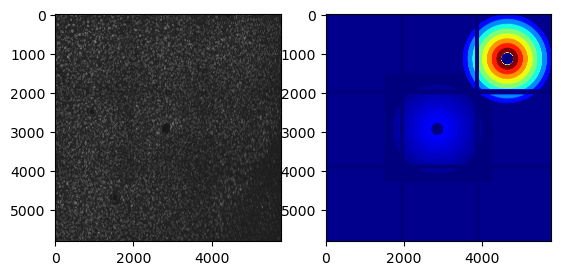

    label        area  intensity_mean  intensity_std  pooled norm mean
0       1  20962052.0      199.272184      73.393918          1.000000
1       2    576568.0      196.987963      64.507739          0.988537
2       3    491113.0      191.875092      63.791448          0.962879
3       4    620556.0      199.004664      62.469432          0.998658
4       5    546760.0      201.643194      67.800806          1.011898
5       6    451728.0      202.680381      66.520277          1.017103
6       7    356616.0      202.715532      67.096899          1.017280
7       8    261616.0      214.294726      78.209444          1.075387
8       9    166552.0      231.789849      85.742071          1.163182
9      11    750348.0      191.593891      62.902039          0.961468
10     21    616664.0      196.312637      66.709998          0.985148
11     31    506778.0      205.319412      70.164914          1.030347
12     41    532411.0      206.877662      71.351745          1.038166
13    

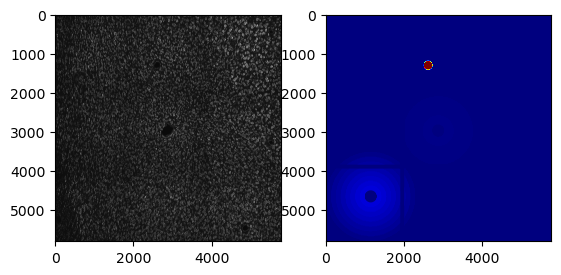

    label        area  intensity_mean  intensity_std  pooled norm mean
0       1  20901068.0      359.299164     209.253931          1.000000
1       2    572146.0      339.645456     181.552408          0.945300
2       3    490956.0      319.744955     163.022128          0.889913
3       4    627839.0      346.247689     182.392213          0.963675
4       5    546760.0      349.462013     181.267493          0.972621
5       6    451728.0      370.641038     196.389681          1.031567
6       7    356616.0      393.109647     208.710129          1.094101
7       8    261616.0      373.295433     202.758457          1.038954
8       9    166552.0      429.626981     229.700184          1.195736
9      11    767516.0      267.773560     149.074133          0.745266
10     21    646948.0      277.981461     148.188994          0.773677
11     31    500152.0      278.574073     149.270339          0.775326
12     41    521892.0      293.714380     158.218850          0.817465
13    

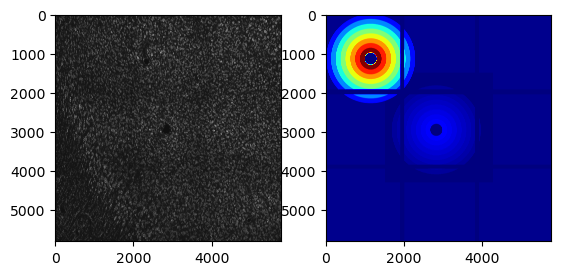

    label        area  intensity_mean  intensity_std  pooled norm mean
0       1  20965531.0      282.513777     142.986459          1.000000
1       2    569938.0      267.871719     125.520236          0.948172
2       3    519532.0      276.529009     123.855812          0.978816
3       4    605219.0      284.611390     128.682477          1.007425
4       5    546760.0      293.190054     131.885021          1.037790
5       6    451728.0      310.284658     147.584009          1.098299
6       7    356616.0      308.303677     146.667855          1.091287
7       8    261616.0      331.845025     167.804592          1.174615
8       9    166552.0      320.396345     147.302939          1.134091
9      11    745986.0      267.066987     123.207974          0.945324
10     21    611780.0      272.008791     133.955008          0.962816
11     31    507146.0      262.664714     120.608392          0.929741
12     41    545001.0      271.965809     128.743917          0.962664
13    

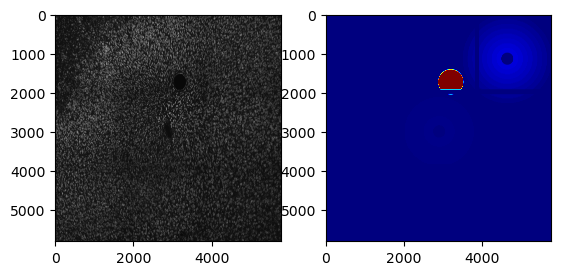

    label        area  intensity_mean  intensity_std  pooled norm mean
0       1  20941290.0      497.384486     281.597209          1.000000
1       2    562216.0      442.674796     229.299932          0.890005
2       3    490321.0      462.431169     264.418995          0.929726
3       4    626053.0      472.068609     270.028575          0.949102
4       5    546760.0      468.039540     272.190750          0.941001
5       6    451728.0      465.232764     274.023474          0.935358
6       7    356616.0      484.444287     300.498554          0.973984
7       8    261616.0      486.680004     292.655276          0.978478
8       9    166552.0      468.212240     277.917638          0.941349
9      11    750061.0      516.152329     254.810929          1.037733
10     21    616412.0      517.646775     249.974419          1.040738
11     31    506514.0      517.209613     247.895635          1.039859
12     41    533407.0      529.022428     248.192722          1.063609
13    

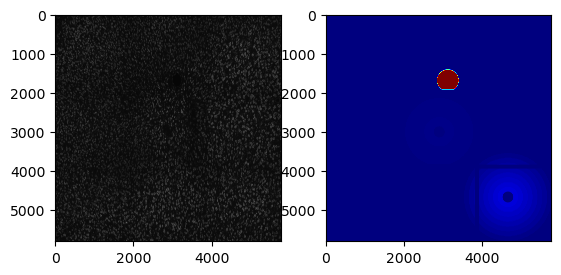

    label        area  intensity_mean  intensity_std  pooled norm mean
0       1  20996404.0      354.092905     239.258392          1.000000
1       2    545826.0      302.462261     189.491266          0.854189
2       3    518040.0      291.391887     183.829922          0.822925
3       4    617261.0      308.913048     203.523582          0.872407
4       5    534352.0      291.157001     192.577254          0.822262
5       6    439360.0      324.040634     223.526240          0.915129
6       7    344288.0      313.408550     211.106098          0.885103
7       8    249216.0      362.129414     249.431571          1.022696
8       9    154168.0      365.231488     259.734106          1.031457
9      11    752081.0      345.120014     234.403268          0.974659
10     21    630896.0      338.432911     224.446217          0.955774
11     31    485236.0      351.666981     238.476736          0.993149
12     41    526082.0      397.226195     279.342886          1.121813
13    

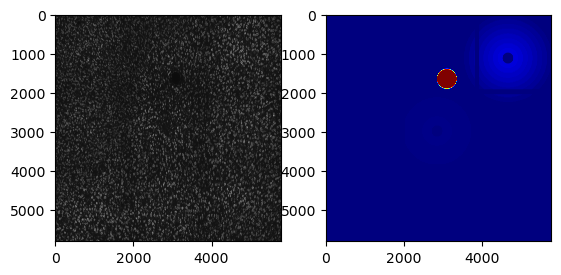

    label        area  intensity_mean  intensity_std  pooled norm mean
0       1  21012323.0      283.464202     174.867167          1.000000
1       2    541638.0      248.824266     141.701834          0.877798
2       3    531056.0      260.368859     159.266741          0.918525
3       4    611494.0      270.307213     172.183417          0.953585
4       5    534352.0      278.156148     182.144188          0.981274
5       6    439360.0      267.745971     171.544576          0.944550
6       7    344288.0      285.000566     196.868833          1.005420
7       8    249216.0      278.054238     180.064828          0.980915
8       9    154168.0      260.328881     167.221960          0.918384
9      11    728798.0      287.457394     181.570939          1.014087
10     21    587900.0      285.867738     175.497465          1.008479
11     31    521727.0      303.829781     202.891912          1.071845
12     41    533308.0      311.059590     209.127736          1.097351
13    

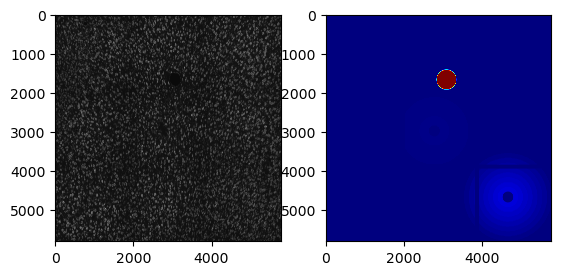

    label        area  intensity_mean  intensity_std  pooled norm mean
0       1  21001445.0      340.447453     233.860902          1.000000
1       2    578226.0      295.772155     194.856455          0.868775
2       3    564486.0      303.334690     213.326218          0.890988
3       4    565632.0      299.119274     200.401006          0.878606
4       5    534352.0      307.035164     220.153812          0.901858
5       6    439360.0      338.373175     233.368241          0.993907
6       7    344288.0      321.100698     220.472371          0.943173
7       8    249216.0      331.983408     229.512897          0.975138
8       9    154168.0      308.972828     192.080956          0.907549
9      11    751927.0      312.777715     190.559606          0.918725
10     21    630702.0      319.024755     204.562351          0.937075
11     31    485477.0      322.050569     201.967439          0.945963
12     41    526301.0      343.207655     211.800136          1.008108
13    

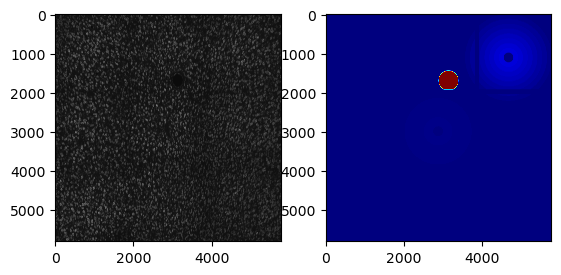

    label        area  intensity_mean  intensity_std  pooled norm mean
0       1  21084602.0      292.219234     170.184781          1.000000
1       2    522394.0      268.722535     152.933330          0.919592
2       3    533446.0      275.676113     161.005309          0.943388
3       4    616998.0      272.527930     160.032348          0.932615
4       5    522808.0      286.633035     177.093776          0.980884
5       6    427784.0      308.167898     197.240524          1.054578
6       7    332672.0      326.634150     203.154292          1.117771
7       8    237656.0      304.728128     183.869147          1.042807
8       9    142568.0      268.035906     152.168090          0.917243
9      11    710264.0      278.207186     148.685807          0.952050
10     21    565486.0      283.409954     155.816547          0.969854
11     31    543677.0      286.680163     161.472154          0.981045
12     41    522808.0      301.525650     167.517193          1.031847
13    

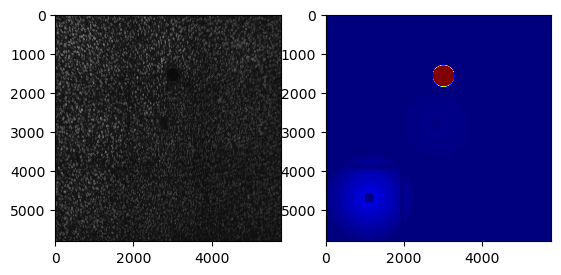

    label        area  intensity_mean  intensity_std  pooled norm mean
0       1  21005241.0      323.402543     187.345094          1.000000
1       2    561794.0      294.076523     158.005868          0.909320
2       3    555684.0      289.465302     155.187815          0.895062
3       4    549091.0      301.893336     161.704798          0.933491
4       5    522808.0      304.564829     158.436982          0.941751
5       6    427784.0      321.579627     178.456565          0.994363
6       7    332672.0      315.176970     166.900482          0.974566
7       8    237656.0      301.201560     157.815003          0.931352
8       9    142568.0      276.678462     130.075334          0.855523
9      11    728558.0      311.045005     177.952015          0.961789
10     21    593382.0      303.415073     173.485441          0.938196
11     31    518878.0      325.558235     185.739826          1.006666
12     41    522808.0      332.230482     180.602035          1.027297
13    

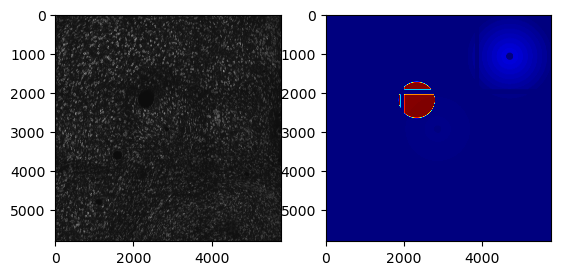

    label        area  intensity_mean  intensity_std  pooled norm mean
0       1  21232626.0      275.528050     156.671086          1.000000
1       2    406425.0      252.690649     135.315386          0.917114
2       3    479463.0      246.485862     125.589569          0.894594
3       4    494630.0      268.225896     148.533962          0.973498
4       5    421387.0      279.510628     161.199631          1.014454
5       6    360824.0      279.021498     161.727776          1.012679
6       7    308357.0      280.171924     169.880137          1.016854
7       8    213616.0      306.854426     171.869635          1.113696
8       9    118624.0      296.020308     168.911913          1.074374
9      11    659539.0      250.160615     126.678083          0.907932
10     21    549757.0      271.093523     145.667730          0.983905
11     31    580045.0      278.037273     158.442098          1.009107
12     41    498824.0      267.706726     144.902677          0.971613
13    

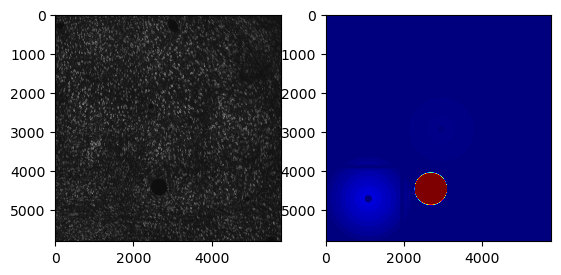

    label        area  intensity_mean  intensity_std  pooled norm mean
0       1  20815214.0      261.716828     140.891191          1.000000
1       2    470897.0      249.318549     129.407366          0.952627
2       3    587282.0      251.698603     133.835527          0.961721
3       4    593928.0      271.036807     153.025592          1.035611
4       5    498824.0      282.743741     157.689781          1.080342
5       6    403808.0      305.561287     185.269008          1.167526
6       7    308756.0      287.501571     151.964318          1.098522
7       8    213616.0      263.939433     137.153187          1.008492
8       9    118624.0      291.748761     152.587321          1.114750
9      11    691230.0      273.112100     131.494887          1.043540
10     21    542226.0      265.135171     123.523084          1.013061
11     31    568938.0      256.658365     122.443009          0.980672
12     41    498824.0      252.654048     117.877137          0.965372
13    

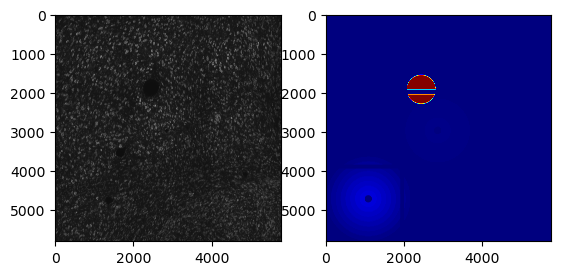

    label        area  intensity_mean  intensity_std  pooled norm mean
0       1  21218562.0      249.966020     122.691373          1.000000
1       2    444030.0      232.420168     112.909218          0.929807
2       3    522684.0      240.271036     114.619148          0.961215
3       4    577255.0      248.939503     127.326613          0.995893
4       5    498824.0      250.308582     131.583960          1.001370
5       6    403808.0      273.445853     147.395847          1.093932
6       7    308756.0      276.828457     145.054303          1.107464
7       8    213616.0      273.691371     145.598688          1.094914
8       9    118624.0      283.647432     144.786744          1.134744
9      11    691230.0      235.710988     106.752844          0.942972
10     21    542226.0      242.219029     110.277747          0.969008
11     31    568938.0      239.662088     112.978015          0.958779
12     41    498824.0      247.597100     122.559977          0.990523
13    

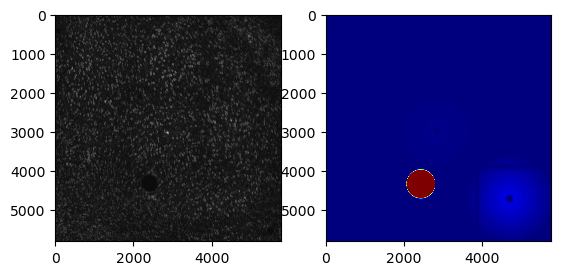

    label        area  intensity_mean  intensity_std  pooled norm mean
0       1  20979119.0      277.292595     147.531689          1.000000
1       2    494724.0      282.526255     157.711144          1.018874
2       3    571329.0      269.343366     137.051160          0.971333
3       4    593928.0      291.598727     164.555172          1.051592
4       5    498824.0      291.147858     157.786809          1.049966
5       6    403808.0      308.930999     179.996614          1.114098
6       7    308756.0      306.271774     169.788352          1.104508
7       8    213616.0      308.143149     181.922606          1.111256
8       9    118624.0      264.473918     120.967096          0.953772
9      11    696090.0      258.993208     133.938597          0.934007
10     21    541238.0      253.271873     125.610197          0.913374
11     31    557132.0      254.260656     128.468376          0.916940
12     41    498824.0      263.092075     135.875883          0.948789
13    

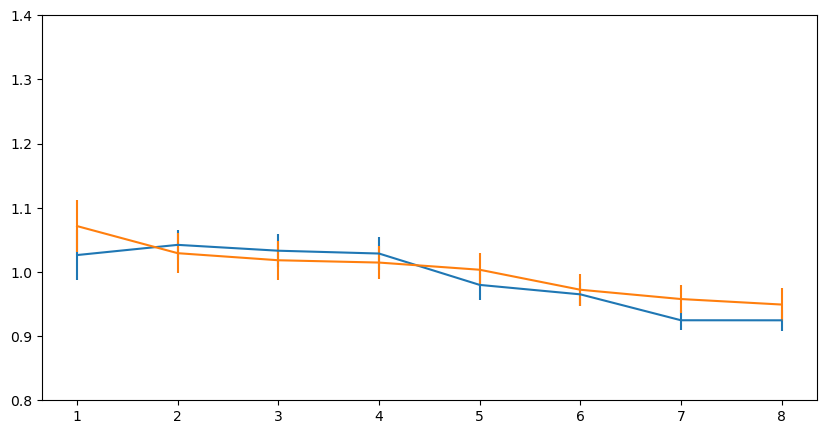

In [91]:
r=40
reach=320
num_regions=np.round(reach/r).astype(int)

nissl_pooled_means, nissl_allmeans = get_means(metadatadf, "nissl", r, reach)
electrode = np.flip(nissl_pooled_means[:, 1:num_regions+1])
control = np.flip(nissl_pooled_means[:, num_regions+1:])
plt.figure(figsize=(10,5))
plt.errorbar(np.linspace(1,num_regions,num_regions), np.mean(electrode, axis=0), np.std(electrode, axis=0)/np.sqrt(num_regions))
plt.errorbar(np.linspace(1,num_regions,num_regions), np.mean(control, axis=0), np.std(control, axis=0)/np.sqrt(num_regions))
# plt.hlines(1, 1, 10)
plt.ylim([0.8,1.4])
root="/Users/eminhanozil/Dropbox (Yanik Lab)/Localization Manuscript 2024/FIGURE_5-STABILITY"
filename="nissl-electrode-r40-reach320.pdf"
plt.savefig(os.path.join(root, filename))
for i in range(num_regions):
    rvs1 = electrode[:,i]
    rvs2 = control[:,i]
    print(stats.ttest_ind(rvs1, rvs2, equal_var=False))

filename = "nissl-electrode-r40-reach320.npy"
np.save(os.path.join(root, filename), electrode)
filename = "nissl-control-r40-reach320.npy"
np.save(os.path.join(root, filename), control)

_rEO008_s03_n1_20x_spot1_zStack


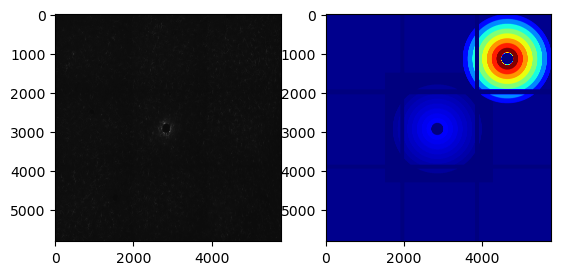

    label        area  intensity_mean  intensity_std  pooled norm mean
0       1  20962052.0      149.589290      28.310733          1.000000
1       2    576568.0      145.957516      25.220502          0.975722
2       3    491113.0      145.833930      25.958068          0.974896
3       4    620556.0      148.998111      25.562928          0.996048
4       5    546760.0      151.335923      27.877751          1.011676
5       6    451728.0      155.261195      28.196009          1.037917
6       7    356616.0      157.684781      25.683322          1.054118
7       8    261616.0      174.443841      30.497341          1.166152
8       9    166552.0      236.931241      78.423447          1.583878
9      11    750348.0      146.308064      26.072077          0.978065
10     21    616664.0      147.156867      25.962308          0.983739
11     31    506778.0      151.945378      32.261201          1.015750
12     41    532411.0      154.319075      30.286891          1.031618
13    

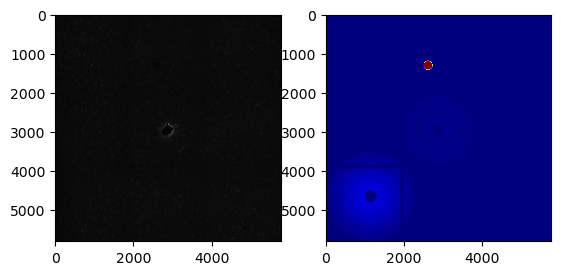

    label        area  intensity_mean  intensity_std  pooled norm mean
0       1  20901068.0      183.058036      50.747869          1.000000
1       2    572146.0      175.178748      47.416848          0.956957
2       3    490956.0      175.999067      47.719998          0.961439
3       4    627839.0      178.163907      46.849072          0.973265
4       5    546760.0      182.216186      53.504310          0.995401
5       6    451728.0      185.619120      51.247422          1.013991
6       7    356616.0      186.551072      49.541745          1.019082
7       8    261616.0      204.464639      61.529752          1.116939
8       9    166552.0      320.811380     240.924110          1.752512
9      11    767516.0      173.151190      50.318984          0.945881
10     21    646948.0      173.369442      50.427919          0.947074
11     31    500152.0      174.531868      48.621466          0.953424
12     41    521892.0      177.987043      47.327195          0.972298
13    

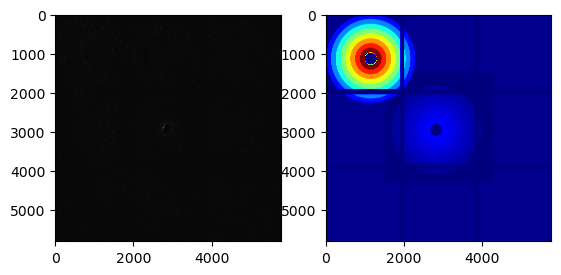

    label        area  intensity_mean  intensity_std  pooled norm mean
0       1  20965531.0      143.980291      26.490602          1.000000
1       2    569938.0      139.897571      22.471457          0.971644
2       3    519532.0      141.415536      25.190516          0.982187
3       4    605219.0      143.931911      26.007555          0.999664
4       5    546760.0      146.359348      27.354421          1.016523
5       6    451728.0      147.903648      25.229186          1.027249
6       7    356616.0      149.562072      24.715650          1.038768
7       8    261616.0      160.103270      30.339806          1.111980
8       9    166552.0      188.291795      52.037567          1.307761
9      11    745986.0      149.269996      31.802253          1.036739
10     21    611780.0      151.977703      35.040113          1.055545
11     31    507146.0      152.184000      35.460202          1.056978
12     41    545001.0      152.717300      37.852560          1.060682
13    

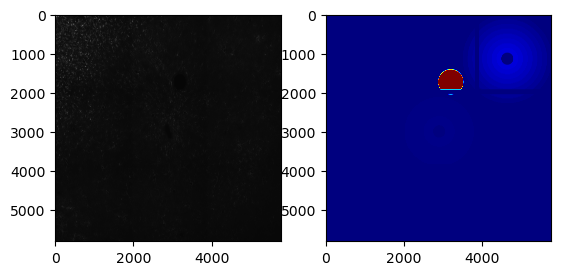

    label        area  intensity_mean  intensity_std  pooled norm mean
0       1  20941290.0      216.491482     111.859984          1.000000
1       2    562216.0      185.251033      39.492248          0.855697
2       3    490321.0      189.537089      46.403383          0.875494
3       4    626053.0      194.541772      49.674572          0.898612
4       5    546760.0      198.325536      52.970207          0.916089
5       6    451728.0      204.124119      57.833356          0.942874
6       7    356616.0      212.660711      65.147341          0.982305
7       8    261616.0      230.009560      79.047532          1.062442
8       9    166552.0      228.672673      65.204087          1.056266
9      11    750061.0      195.497809      36.282606          0.903028
10     21    616412.0      200.133687      41.314302          0.924441
11     31    506514.0      205.337618      43.409838          0.948479
12     41    533407.0      208.067620      47.840599          0.961089
13    

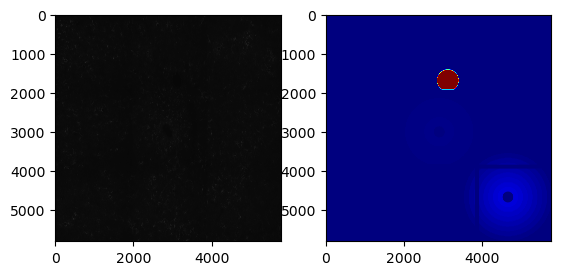

    label        area  intensity_mean  intensity_std  pooled norm mean
0       1  20996404.0      165.531752      46.162352          1.000000
1       2    545826.0      161.171577      51.346397          0.973660
2       3    518040.0      156.184343      43.166043          0.943531
3       4    617261.0      154.565448      41.193064          0.933751
4       5    534352.0      156.467228      42.253761          0.945240
5       6    439360.0      167.711321      54.949475          1.013167
6       7    344288.0      177.101697      63.641084          1.069896
7       8    249216.0      189.612019      66.697610          1.145472
8       9    154168.0      188.438223      50.138389          1.138381
9      11    752081.0      157.384190      36.689203          0.950779
10     21    630896.0      158.011866      31.543354          0.954571
11     31    485236.0      163.432888      38.581915          0.987320
12     41    526082.0      168.198564      43.988763          1.016111
13    

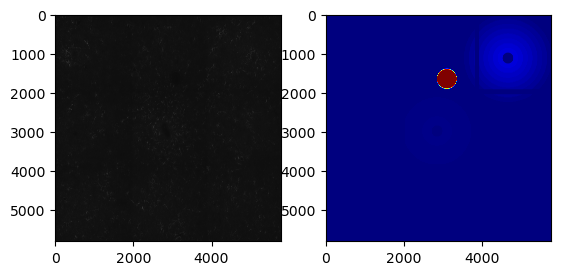

    label        area  intensity_mean  intensity_std  pooled norm mean
0       1  21012323.0      148.652617      29.641735          1.000000
1       2    541638.0      141.637581      25.027651          0.952809
2       3    531056.0      144.300143      31.839621          0.970721
3       4    611494.0      147.637650      33.216042          0.993172
4       5    534352.0      153.147788      40.678429          1.030239
5       6    439360.0      157.300496      41.922913          1.058175
6       7    344288.0      159.319209      45.689846          1.071755
7       8    249216.0      172.440485      55.671903          1.160023
8       9    154168.0      165.320384      42.431447          1.112126
9      11    728798.0      143.702116      21.484092          0.966698
10     21    587900.0      148.783973      29.920299          1.000884
11     31    521727.0      155.101384      40.831380          1.043381
12     41    533308.0      159.815641      41.452078          1.075095
13    

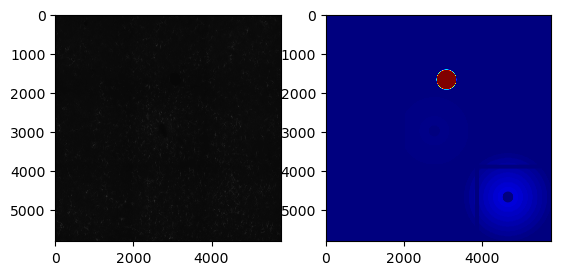

    label        area  intensity_mean  intensity_std  pooled norm mean
0       1  21001445.0      170.016975      52.372223          1.000000
1       2    578226.0      158.753102      45.990143          0.933749
2       3    564486.0      163.525574      56.708678          0.961819
3       4    565632.0      169.466660      63.872474          0.996763
4       5    534352.0      174.682936      66.644812          1.027444
5       6    439360.0      182.326564      78.551348          1.072402
6       7    344288.0      191.720095      83.720027          1.127653
7       8    249216.0      205.239848      92.896518          1.207173
8       9    154168.0      199.284430      70.705647          1.172144
9      11    751927.0      167.066526      58.940518          0.982646
10     21    630702.0      170.541189      58.753105          1.003083
11     31    485477.0      173.693295      63.407201          1.021623
12     41    526301.0      177.729269      70.395092          1.045362
13    

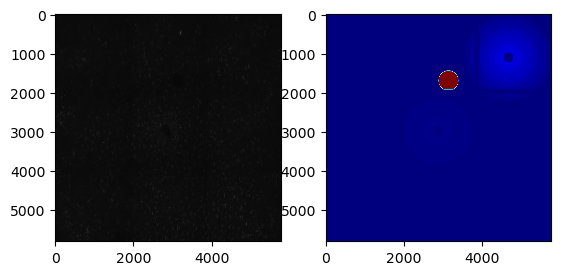

    label        area  intensity_mean  intensity_std  pooled norm mean
0       1  21084602.0      167.194424      50.199928          1.000000
1       2    522394.0      159.304121      46.993576          0.952808
2       3    533446.0      159.713532      46.938895          0.955256
3       4    616998.0      164.844093      50.962039          0.985943
4       5    522808.0      169.171575      53.252926          1.011825
5       6    427784.0      181.364754      67.650600          1.084754
6       7    332672.0      190.458455      67.246450          1.139144
7       8    237656.0      204.082173      75.291910          1.220628
8       9    142568.0      196.147431      59.198751          1.173170
9      11    710264.0      155.048626      33.277940          0.927355
10     21    565486.0      156.600819      33.433320          0.936639
11     31    543677.0      157.644454      33.459239          0.942881
12     41    522808.0      158.648837      27.495913          0.948888
13    

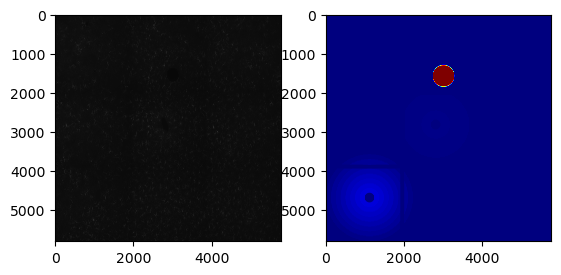

    label        area  intensity_mean  intensity_std  pooled norm mean
0       1  21005241.0      171.677039      44.414892          1.000000
1       2    561794.0      158.074116      39.184044          0.920764
2       3    555684.0      163.339670      45.665487          0.951436
3       4    549091.0      168.110534      47.253301          0.979225
4       5    522808.0      172.448486      50.036102          1.004494
5       6    427784.0      176.511616      50.753181          1.028161
6       7    332672.0      187.703215      58.185418          1.093351
7       8    237656.0      201.856292      58.951836          1.175791
8       9    142568.0      190.140165      47.003330          1.107546
9      11    728558.0      168.526349      43.837320          0.981648
10     21    593382.0      169.548259      48.735637          0.987600
11     31    518878.0      169.329850      46.356034          0.986328
12     41    522808.0      169.782230      46.077743          0.988963
13    

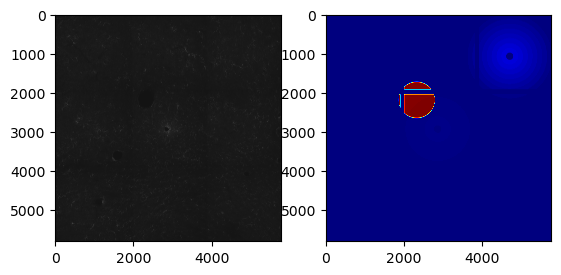

    label        area  intensity_mean  intensity_std  pooled norm mean
0       1  21232626.0      144.376464      23.190218          1.000000
1       2    406425.0      139.471912      20.276992          0.966029
2       3    479463.0      141.983381      21.247472          0.983425
3       4    494630.0      145.282458      22.156186          1.006275
4       5    421387.0      148.426933      23.236587          1.028055
5       6    360824.0      150.575333      24.793978          1.042935
6       7    308357.0      153.277834      23.302694          1.061654
7       8    213616.0      164.343780      28.497689          1.138300
8       9    118624.0      188.478858      42.658295          1.305468
9      11    659539.0      138.797797      18.954092          0.961360
10     21    549757.0      143.086955      19.805314          0.991068
11     31    580045.0      145.303882      20.821081          1.006424
12     41    498824.0      147.184237      20.940477          1.019448
13    

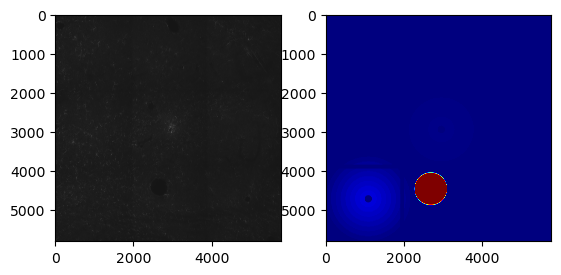

    label        area  intensity_mean  intensity_std  pooled norm mean
0       1  20815214.0      142.390266      20.956975          1.000000
1       2    470897.0      143.041387      20.726500          1.004573
2       3    587282.0      144.206465      21.247357          1.012755
3       4    593928.0      143.736650      19.611060          1.009456
4       5    498824.0      147.010743      20.609539          1.032449
5       6    403808.0      149.306772      20.681228          1.048574
6       7    308756.0      155.609293      23.584038          1.092837
7       8    213616.0      161.737215      24.260689          1.135873
8       9    118624.0      182.264972      36.757627          1.280038
9      11    691230.0      146.699729      23.835020          1.030265
10     21    542226.0      146.963707      24.775741          1.032119
11     31    568938.0      147.619561      24.621369          1.036725
12     41    498824.0      149.411061      24.251503          1.049307
13    

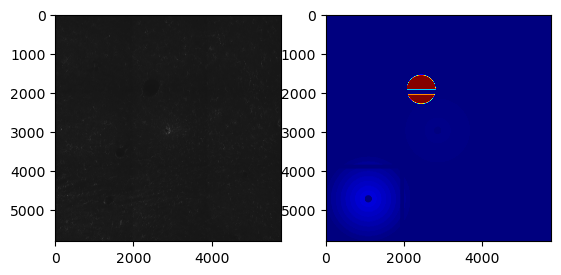

    label        area  intensity_mean  intensity_std  pooled norm mean
0       1  21218562.0      134.049646      17.367984          1.000000
1       2    444030.0      131.451508      15.430115          0.980618
2       3    522684.0      133.335568      16.351531          0.994673
3       4    577255.0      135.319718      17.002578          1.009475
4       5    498824.0      136.795184      17.845138          1.020482
5       6    403808.0      138.501169      17.273930          1.033208
6       7    308756.0      142.421689      18.474572          1.062455
7       8    213616.0      147.160746      20.523935          1.097808
8       9    118624.0      158.415683      29.083133          1.181769
9      11    691230.0      139.930518      24.021630          1.043871
10     21    542226.0      140.285569      24.188307          1.046520
11     31    568938.0      138.399043      20.736947          1.032446
12     41    498824.0      138.834274      21.031135          1.035693
13    

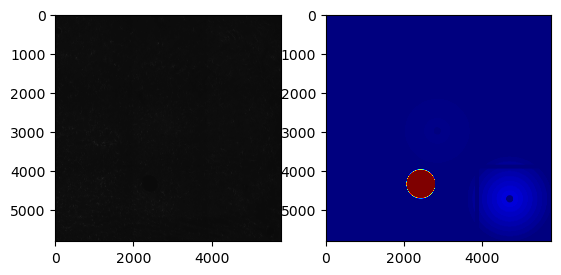

    label        area  intensity_mean  intensity_std  pooled norm mean
0       1  20979119.0      143.432899      24.621071          1.000000
1       2    494724.0      138.519461      19.215600          0.965744
2       3    571329.0      139.350304      18.188990          0.971537
3       4    593928.0      142.330161      19.755999          0.992312
4       5    498824.0      146.776033      24.421408          1.023308
5       6    403808.0      149.447284      25.300179          1.041932
6       7    308756.0      149.797406      22.534930          1.044373
7       8    213616.0      152.166575      22.810378          1.060890
8       9    118624.0      154.212326      19.824257          1.075153
9      11    696090.0      137.014612      18.704636          0.955252
10     21    541238.0      136.364546      18.929151          0.950720
11     31    557132.0      138.231904      20.976736          0.963739
12     41    498824.0      139.002620      19.724312          0.969113
13    

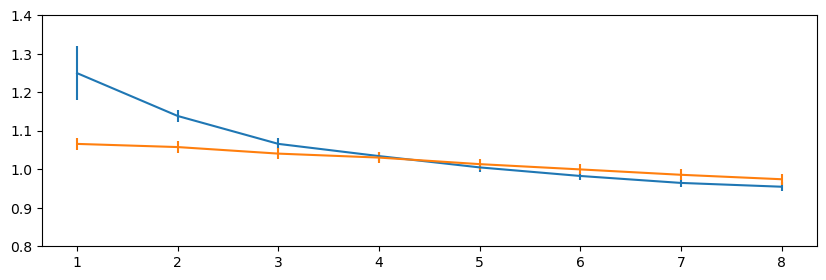

In [102]:
channel = "gfap"
r=40
reach=320
num_regions=np.round(reach/r).astype(int)

gfap_pooled_means, gfap_allmeans = get_means(metadatadf, channel, r, reach)
electrode = np.flip(gfap_pooled_means[:, 1:num_regions+1])
control = np.flip(gfap_pooled_means[:, num_regions+1:])

plt.figure(figsize=(10,3))
plt.errorbar(np.linspace(1,num_regions,num_regions), np.mean(electrode, axis=0), np.std(electrode, axis=0)/np.sqrt(num_regions))
plt.errorbar(np.linspace(1,num_regions,num_regions), np.mean(control, axis=0), np.std(control, axis=0)/np.sqrt(num_regions))
plt.ylim([0.8,1.4])
root="/Users/eminhanozil/Dropbox (Yanik Lab)/Localization Manuscript 2024/FIGURE_5-STABILITY"
filename="gfap-electrode-r40-reach320.pdf"
plt.savefig(os.path.join(root, filename))

for i in range(num_regions):
    rvs1 = electrode[:,i]
    rvs2 = control[:,i]
    print(stats.ttest_ind(rvs1, rvs2, equal_var=False))

filename = channel+"-electrode-r40-reach320.npy"
np.save(os.path.join(root, filename), electrode)
filename = channel+"-control-r40-reach320.npy"
np.save(os.path.join(root, filename), control)

_rEO008_s03_n1_20x_spot1_zStack


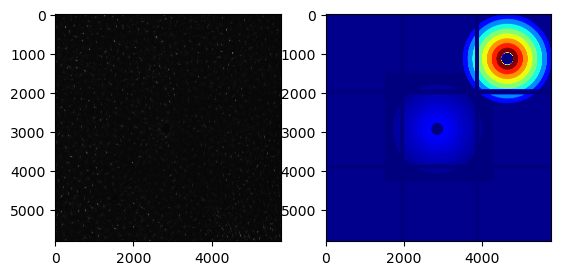

    label        area  intensity_mean  intensity_std  pooled norm mean
0       1  20962052.0      168.665488     105.188308          1.000000
1       2    576568.0      159.612802      83.939702          0.946328
2       3    491113.0      163.062992      87.180380          0.966783
3       4    620556.0      163.485071      89.358520          0.969286
4       5    546760.0      164.171765      87.614373          0.973357
5       6    451728.0      162.572063      72.660060          0.963873
6       7    356616.0      162.542488      75.832704          0.963697
7       8    261616.0      167.966179      69.911134          0.995854
8       9    166552.0      204.706746     109.667924          1.213685
9      11    750348.0      156.765653      81.068276          0.929447
10     21    616664.0      164.381592      92.050216          0.974601
11     31    506778.0      164.375060      94.531448          0.974562
12     41    532411.0      164.721448      92.099906          0.976616
13    

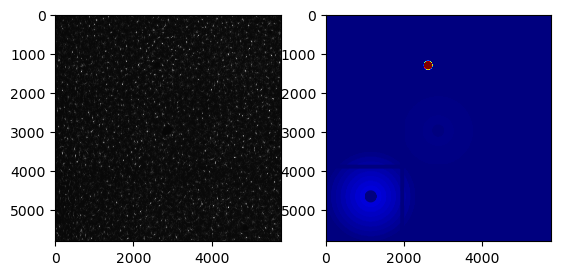

    label        area  intensity_mean  intensity_std  pooled norm mean
0       1  20901068.0      252.316026     261.603454          1.000000
1       2    572146.0      222.743676     179.377622          0.882796
2       3    490956.0      249.327879     258.299337          0.988157
3       4    627839.0      248.404538     244.690409          0.984498
4       5    546760.0      242.020365     230.276983          0.959195
5       6    451728.0      237.605218     209.110612          0.941697
6       7    356616.0      254.293402     281.569351          1.007837
7       8    261616.0      248.360930     232.732026          0.984325
8       9    166552.0      273.065529     251.116667          1.082236
9      11    767516.0      233.940220     248.977707          0.927171
10     21    646948.0      232.043667     232.144001          0.919655
11     31    500152.0      247.964079     252.038385          0.982752
12     41    521892.0      220.270418     193.964206          0.872994
13    

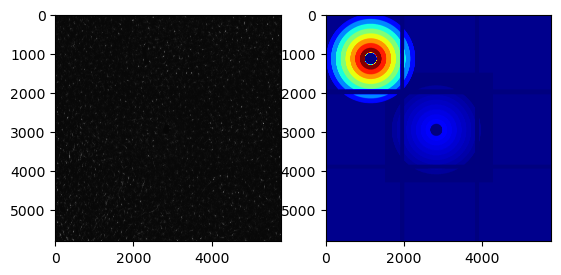

    label        area  intensity_mean  intensity_std  pooled norm mean
0       1  20965531.0      190.396246     137.311313          1.000000
1       2    569938.0      178.748501     103.280427          0.938824
2       3    519532.0      178.881871     111.569467          0.939524
3       4    605219.0      181.025564     121.439408          0.950783
4       5    546760.0      190.174598     121.665589          0.998836
5       6    451728.0      185.598880     112.377781          0.974803
6       7    356616.0      194.528989     134.765535          1.021706
7       8    261616.0      183.173804      83.776811          0.962066
8       9    166552.0      210.788643     118.923395          1.107105
9      11    745986.0      181.995415     126.839070          0.955877
10     21    611780.0      177.174107     115.193394          0.930555
11     31    507146.0      184.803481     123.606604          0.970626
12     41    545001.0      191.110449     130.505917          1.003751
13    

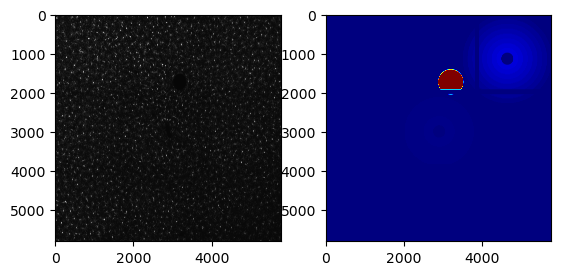

    label        area  intensity_mean  intensity_std  pooled norm mean
0       1  20941290.0      305.764379     285.132552          1.000000
1       2    562216.0      279.280794     273.974320          0.913386
2       3    490321.0      288.087755     259.126899          0.942189
3       4    626053.0      284.418284     268.392065          0.930188
4       5    546760.0      295.919195     288.583992          0.967801
5       6    451728.0      280.116490     252.459474          0.916119
6       7    356616.0      297.358450     284.562645          0.972508
7       8    261616.0      293.530239     284.461764          0.959988
8       9    166552.0      254.511282     199.725414          0.832377
9      11    750061.0      305.335806     260.555615          0.998598
10     21    616412.0      314.344597     258.155702          1.028062
11     31    506514.0      319.275757     272.468215          1.044189
12     41    533407.0      325.990332     284.403136          1.066149
13    

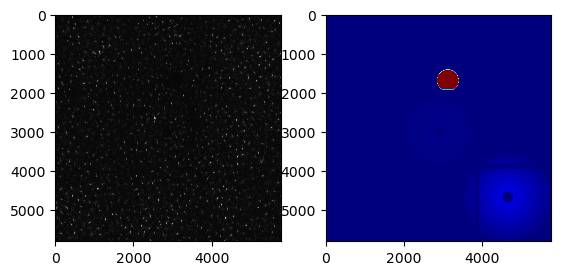

    label        area  intensity_mean  intensity_std  pooled norm mean
0       1  20996404.0      225.887878     251.298415          1.000000
1       2    545826.0      207.423712     208.284699          0.918260
2       3    518040.0      205.005185     223.090130          0.907553
3       4    617261.0      193.846857     174.243797          0.858155
4       5    534352.0      204.135134     225.933810          0.903701
5       6    439360.0      212.368477     217.438824          0.940150
6       7    344288.0      232.186486     274.151196          1.027884
7       8    249216.0      210.642266     204.074723          0.932508
8       9    154168.0      211.000538     211.310092          0.934094
9      11    752081.0      226.852070     260.820380          1.004268
10     21    630896.0      221.964687     234.942639          0.982632
11     31    485236.0      237.244918     292.610103          1.050277
12     41    526082.0      214.844393     197.164562          0.951111
13    

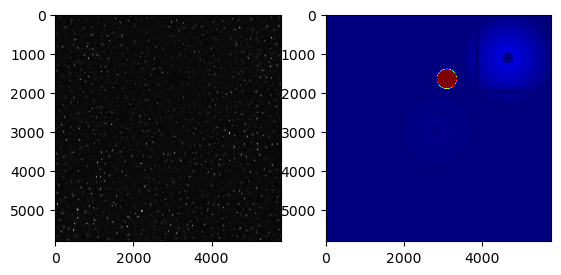

    label        area  intensity_mean  intensity_std  pooled norm mean
0       1  21012323.0      198.443125     209.644197          1.000000
1       2    541638.0      179.270324     167.532724          0.903384
2       3    531056.0      184.741086     159.736264          0.930952
3       4    611494.0      189.018543     177.988920          0.952507
4       5    534352.0      183.397423     136.618163          0.924181
5       6    439360.0      201.946875     227.320218          1.017656
6       7    344288.0      181.829576     140.977466          0.916281
7       8    249216.0      190.573856     165.589048          0.960345
8       9    154168.0      182.004437     156.402264          0.917162
9      11    728798.0      196.949172     203.377855          0.992472
10     21    587900.0      199.537520     205.723162          1.005515
11     31    521727.0      204.635334     211.351192          1.031204
12     41    533308.0      209.497281     216.749331          1.055704
13    

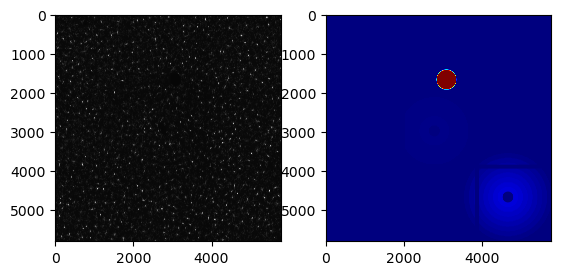

    label        area  intensity_mean  intensity_std  pooled norm mean
0       1  21001445.0      235.545097     273.415476          1.000000
1       2    578226.0      218.852345     242.105775          0.929131
2       3    564486.0      226.596056     263.469301          0.962007
3       4    565632.0      211.191324     217.538088          0.896607
4       5    534352.0      222.583666     250.229184          0.944973
5       6    439360.0      233.845994     269.260231          0.992787
6       7    344288.0      233.483645     280.371845          0.991248
7       8    249216.0      242.454566     315.863921          1.029334
8       9    154168.0      220.456411     217.380147          0.935941
9      11    751927.0      219.893897     254.164069          0.933553
10     21    630702.0      249.098045     318.669330          1.057539
11     31    485477.0      232.484235     297.423226          0.987005
12     41    526301.0      249.846339     338.430248          1.060716
13    

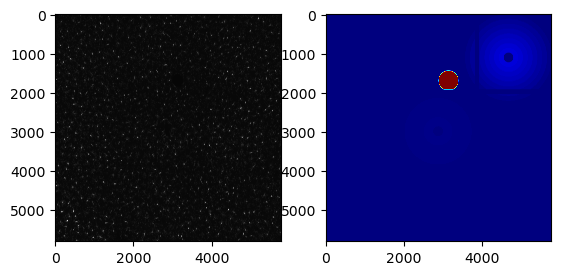

    label        area  intensity_mean  intensity_std  pooled norm mean
0       1  21084602.0      209.596764     204.012829          1.000000
1       2    522394.0      198.687010     180.357356          0.947949
2       3    533446.0      195.715133     178.888046          0.933770
3       4    616998.0      195.485368     166.856254          0.932674
4       5    522808.0      194.422187     161.983821          0.927601
5       6    427784.0      206.122249     174.684818          0.983423
6       7    332672.0      209.208286     182.865246          0.998147
7       8    237656.0      201.919312     165.627026          0.963370
8       9    142568.0      200.372664     192.164819          0.955991
9      11    710264.0      186.781100     138.491141          0.891145
10     21    565486.0      197.078048     170.150847          0.940272
11     31    543677.0      198.735946     187.081961          0.948182
12     41    522808.0      203.277687     183.801544          0.969851
13    

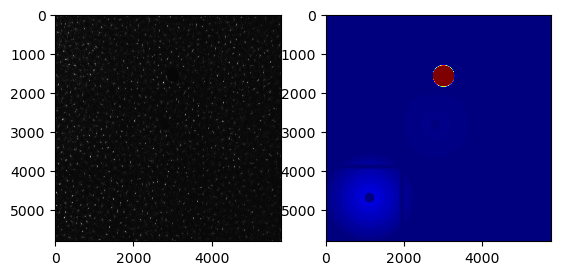

    label        area  intensity_mean  intensity_std  pooled norm mean
0       1  21005241.0      216.644109     195.346788          1.000000
1       2    561794.0      207.024050     204.277970          0.955595
2       3    555684.0      204.646898     179.099933          0.944622
3       4    549091.0      209.668164     222.497056          0.967800
4       5    522808.0      206.218461     190.712008          0.951877
5       6    427784.0      214.026969     206.277541          0.987920
6       7    332672.0      193.242699     133.743798          0.891982
7       8    237656.0      201.323257     189.054610          0.929281
8       9    142568.0      219.585847     224.009405          1.013579
9      11    728558.0      233.686887     277.551794          1.078667
10     21    593382.0      219.661965     227.219000          1.013930
11     31    518878.0      207.336516     202.009079          0.957037
12     41    522808.0      216.680772     223.462165          1.000169
13    

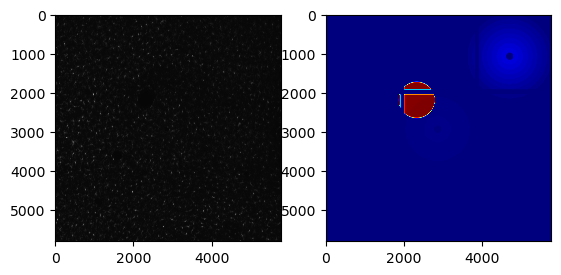

    label        area  intensity_mean  intensity_std  pooled norm mean
0       1  21232626.0      195.218765     148.944388          1.000000
1       2    406425.0      185.142607     119.734662          0.948385
2       3    479463.0      189.270359     130.198910          0.969530
3       4    494630.0      194.959867     140.544765          0.998674
4       5    421387.0      197.925484     141.636853          1.013865
5       6    360824.0      190.075910     112.169899          0.973656
6       7    308357.0      191.207328     119.129766          0.979452
7       8    213616.0      197.035550     128.065857          1.009306
8       9    118624.0      206.245675     136.222403          1.056485
9      11    659539.0      170.723040      97.878981          0.874522
10     21    549757.0      177.497400     106.671998          0.909223
11     31    580045.0      175.594830      98.342121          0.899477
12     41    498824.0      181.535754      90.968727          0.929909
13    

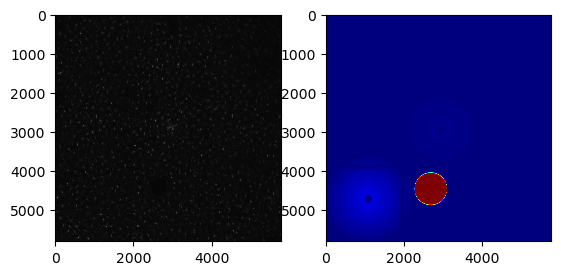

    label        area  intensity_mean  intensity_std  pooled norm mean
0       1  20815214.0      182.905861     114.711252          1.000000
1       2    470897.0      193.037325     147.517322          1.055392
2       3    587282.0      185.587680     116.788680          1.014662
3       4    593928.0      189.474216     128.944154          1.035911
4       5    498824.0      193.875541     136.767521          1.059974
5       6    403808.0      189.804590     118.945493          1.037717
6       7    308756.0      217.179569     173.692926          1.187384
7       8    213616.0      210.606223     129.347048          1.151446
8       9    118624.0      237.311868     142.652546          1.297454
9      11    691230.0      200.882553     150.024716          1.098284
10     21    542226.0      195.238934     140.395404          1.067429
11     31    568938.0      189.125314     122.567711          1.034004
12     41    498824.0      189.043418     118.984965          1.033556
13    

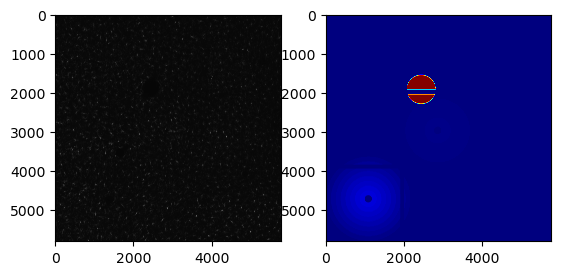

    label        area  intensity_mean  intensity_std  pooled norm mean
0       1  21218562.0      183.445287     116.116352          1.000000
1       2    444030.0      178.903160      94.870830          0.975240
2       3    522684.0      184.878837     116.476830          1.007815
3       4    577255.0      182.172951     104.280298          0.993064
4       5    498824.0      183.493543     109.099864          1.000263
5       6    403808.0      190.271889     120.749412          1.037213
6       7    308756.0      201.343828     135.705125          1.097569
7       8    213616.0      208.032933     139.610503          1.134033
8       9    118624.0      205.609034     133.536175          1.120819
9      11    691230.0      195.612699     128.621866          1.066327
10     21    542226.0      206.657091     151.043171          1.126533
11     31    568938.0      192.239012     121.719892          1.047937
12     41    498824.0      191.523501     107.716223          1.044036
13    

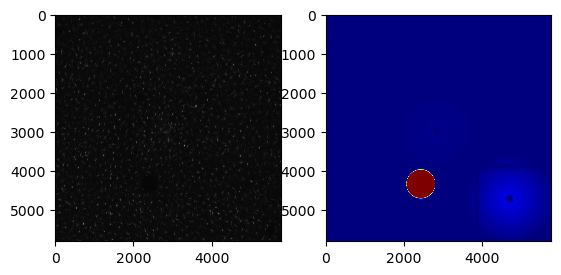

    label        area  intensity_mean  intensity_std  pooled norm mean
0       1  20979119.0      202.639422     136.601921          1.000000
1       2    494724.0      203.395809     151.641814          1.003733
2       3    571329.0      208.478273     147.690420          1.028814
3       4    593928.0      204.912575     133.267829          1.011218
4       5    498824.0      219.753639     170.784263          1.084457
5       6    403808.0      220.640349     161.609238          1.088832
6       7    308756.0      232.389369     179.804478          1.146812
7       8    213616.0      246.191194     188.311364          1.214923
8       9    118624.0      263.120886     167.050952          1.298468
9      11    696090.0      199.382524     131.609394          0.983928
10     21    541238.0      201.392908     141.052288          0.993849
11     31    557132.0      206.285575     149.500897          1.017993
12     41    498824.0      213.156233     166.935467          1.051899
13    

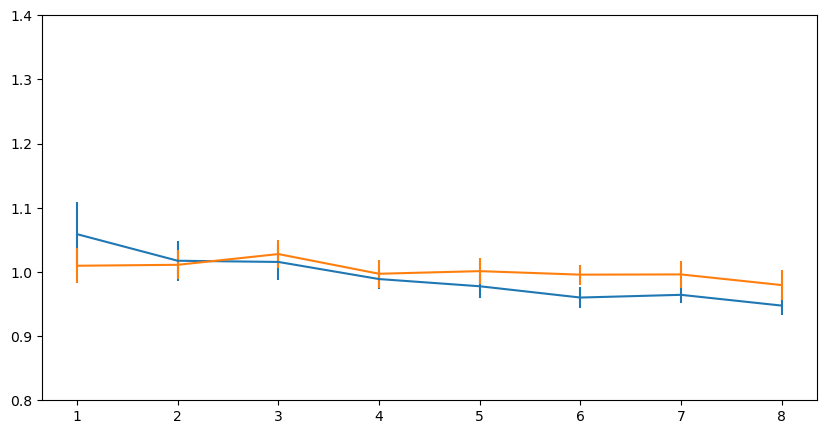

In [93]:
channel = "iba"
r=40
reach=320
num_regions=np.round(reach/r).astype(int)

iba_pooled_means, iba_allmeans = get_means(metadatadf, channel, r, reach)
electrode = np.flip(iba_pooled_means[:, 1:num_regions+1])
control = np.flip(iba_pooled_means[:, num_regions+1:])

plt.figure(figsize=(10,5))
plt.errorbar(np.linspace(1,num_regions,num_regions), np.mean(electrode, axis=0), np.std(electrode, axis=0)/np.sqrt(num_regions))
plt.errorbar(np.linspace(1,num_regions,num_regions), np.mean(control, axis=0), np.std(control, axis=0)/np.sqrt(num_regions))
plt.ylim([0.8,1.4])
root="/Users/eminhanozil/Dropbox (Yanik Lab)/Localization Manuscript 2024/FIGURE_5-STABILITY"
filename="iba-electrode-r40-reach320.pdf"
plt.savefig(os.path.join(root, filename))

for i in range(num_regions):
    rvs1 = electrode[:,i]
    rvs2 = control[:,i]
    print(stats.ttest_ind(rvs1, rvs2, equal_var=False))

root="/Users/eminhanozil/Dropbox (Yanik Lab)/Localization Manuscript 2024/FIGURE_5-STABILITY"
filename = channel+"-electrode-r40-reach320.npy"
np.save(os.path.join(root, filename), electrode)
filename = channel+"-control-r40-reach320.npy"
np.save(os.path.join(root, filename), control)

In [306]:
root="/Users/eminhanozil/Dropbox (Yanik Lab)/Localization Manuscript 2024/RAT DATA"
animal_id="rEO_08"
spot="s06_n3_20x_spot4"
workingdir=os.path.join(root, animal_id, "histology", spot)
filename="_rEO008_s06_n3_20x_spot4_iba-stack.tif"

data = imread(os.path.join(workingdir, filename))

In [307]:
ibaMaxProj=np.max(data[7:15,:,:], axis=0)
# gfapMaxProj8bit = (gfapMaxProj/256).astype('uint8')
# gfapMaxProj8bit = gfapMaxProj8bit/np.max(gfapMaxProj8bit)*255
ibaMaxProj = cv2.cvtColor(ibaMaxProj, cv2.COLOR_GRAY2RGB)
ibaMaxProj[:,:,0]=ibaMaxProj[:,:,0]*30
ibaMaxProj[:,:,1]=ibaMaxProj[:,:,1]*30
ibaMaxProj[:,:,2]=ibaMaxProj[:,:,2]


# electrodesMaxProj=np.max(nissl_data[1:4,:,:], axis=0)
# electrodesMaxProj8Bit = (electrodesMaxProj/256).astype('uint8')


# center=[2750, 2900]  #Center of bundle
# cx,cy = center
# r=200
# roi=skimage.morphology.disk(r)
# mask=np.zeros_like(electrodesMaxProjRGBA[:,:,0])
# mask[cx-r:cx+r+1, cy-r:cy+r+1]=roi
# electrodesMaxProj=electrodesMaxProj*mask
# electrodesMaxProj=electrodesMaxProj*(electrodesMaxProj>200)
# electrodesMaxProjRGBA = cv2.cvtColor(electrodesMaxProj, cv2.COLOR_GRAY2RGB)
# electrodesMaxProjRGBA[:,:,0]=electrodesMaxProjRGBA[:,:,0]
# electrodesMaxProjRGBA[:,:,1]=electrodesMaxProjRGBA[:,:,1]
# electrodesMaxProjRGBA[:,:,2]=electrodesMaxProjRGBA[:,:,2]*30

merged_iba_elec=electrodesMaxProjRGBA+ibaMaxProj
cv2.imwrite(os.path.join(workingdir, "iba_maxProj-merged.tiff"), merged_iba_elec)

True

In [310]:
#325nm/pixel
start=7
stop=15
roiscaler=np.round(50/0.325).astype(int)
x,y=np.shape(data[0,:,:])
center=[2750, 2900]  #Center of bundle
cx,cy = center

i=0
rbase=150
data_reshaped=np.moveaxis(data, 0, -1)
rprev=0
r=rbase
roiRef=250

vesselLocation=[1800, 2950]
vesselSize=200

mask=np.zeros_like(data_reshaped[:,:,0])
while cx+r<x and cy+r<y and cx-r>0 and cy-r>0: 
    roi=skimage.morphology.disk(r)
    roiprev=skimage.morphology.disk(rprev)
    
    mask[cx-r:cx+r+1, cy-r:cy+r+1]=mask[cx-r:cx+r+1, cy-r:cy+r+1]+roi

    i=i+1
    rprev=r
    r=rbase+roiscaler*i


mask=i+1-mask
reference=i+2
vessel=i+3
mask[:roiRef,:]=reference
mask[-roiRef:,:]=reference
mask[:,:roiRef]=reference
mask[:,-roiRef:]=reference


vesselMask=skimage.morphology.disk(vesselSize)*vessel
mask[vesselLocation[0]-vesselSize:vesselLocation[0]+vesselSize+1, vesselLocation[1]-vesselSize:vesselLocation[1]+vesselSize+1]=vesselMask


props=skimage.measure.regionprops_table(mask, data_reshaped[:,:,start:stop], properties=('label', 'area', 'intensity_mean', 'intensity_std'),)
df=pd.DataFrame(props)
mean_columns=[column for column in df.columns.values if "intensity_mean" in column]

df["pooled norm mean"]=(df[mean_columns]/df[mean_columns].loc[reference-1]).mean(axis=1)
df["pooled mean"]=df[mean_columns].mean(axis=1)
std_columns=[column for column in df.columns.values if "intensity_std" in column]
df["pooled std"]=((df[std_columns]**2).mean(axis=1))**0.5
df

label       area  intensity_mean-0  intensity_mean-1  intensity_mean-2  \
0       1    70681.0        167.162476        157.962805        134.701405   
1       2   219592.0        212.004108        193.985441        172.786486   
2       3   368692.0        209.499764        191.540245        186.644807   
3       4   517668.0        188.075245        177.544567        172.759230   
4       5   663192.0        207.844057        190.774426        176.782392   
5       6   754345.0        188.373687        176.129671        167.856185   
6       7   902383.0        196.997216        177.543597        167.943034   
7       8  1079951.0        194.338104        182.885657        168.603697   
8       9  1262844.0        196.204217        180.976982        177.984160   
9      10  1411740.0        187.562495        181.260336        172.552685   
10     11  1560700.0        191.147068        179.226240        173.314705   
11     12  1709776.0        186.944231        183.050031        180.003234   
12     13  1858732.0        196.402927        180.026133        175.312878   
13     14  2007796.0        198.339165        193.995864        180.316639   
14     15  2156820.0        205.118810        189.528026        179.687841   
15     16  2305820.0        207.063836        192.906948        178.717221   
16     17  2338946.0        206.559558        188.853659        178.455659   
17     18  6580490.0        204.847587        192.906814        185.084753   
18     19  5535000.0        201.494179        190.075124        183.576887   
19     20   125629.0        135.562084        135.412556        134.270678   

    intensity_mean-3  intensity_mean-4  intensity_mean-5  intensity_mean-6  \
0         131.619601        130.034578        127.936588        125.093052   
1         167.467950        158.840176        156.401709        155.816815   
2         173.927343        157.830127        150.583227        149.836240   
3         176.271697        162.981144        152.028283        147.852450   
4         166.454600        159.295406        153.880398        148.105080   
5         160.999739        151.903258        145.782175        145.615423   
6         162.932358        154.291837        148.955859        150.999246   
7         162.154126        156.363287        150.171071        149.143168   
8         165.014486        160.061149        156.341203        154.014917   
9         166.736004        163.523674        156.273013        151.169987   
10        169.092688        166.161552        161.159377        157.622327   
11        174.094975        166.841078        160.641048        161.019897   
12        171.787865        167.753658        160.411958        156.576601   
13        171.140680        168.833431        166.456756        163.878741   
14        173.503074        169.358469        166.332945        165.797324   
15        170.673321        167.081031        165.426387        166.939126   
16        176.173221        172.497173        170.435822        169.349643   
17        177.778495        173.298451        167.774741        165.927856   
18        177.425239        169.118458        166.471852        164.168008   
19        130.300034        125.552619        124.746062        131.130519   

    intensity_mean-7  ...  intensity_std-1  intensity_std-2  intensity_std-3  \
0         121.870984  ...       162.182332        58.401629        52.134268   
1         153.198623  ...       196.370224       135.455617       128.859824   
2         148.048227  ...       222.224191       192.753082       147.988511   
3         149.418535  ...       171.637311       163.997704       182.193460   
4         144.315553  ...       197.907681       176.433620       142.541765   
5         146.422919  ...       152.250084       156.917229       137.532651   
6         150.944884  ...       164.121427       142.840250       148.149086   
7         150.331620  ...       187.963927       134.951783       134.967894   
8     

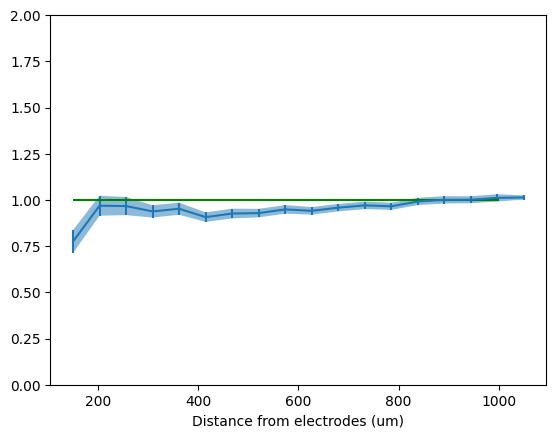

In [311]:
numRois=reference-1
dist=np.linspace(0,numRois*50, numRois)+rbase
# means=df[df["label"]<=numRois]["pooled mean"]/df[df["label"]==reference]["pooled mean"].values[0]
means=df[df["label"]<=numRois]["pooled mean"]/df[df["label"]==reference]["pooled mean"].values[0]
stds=df[df["label"]<=numRois]["pooled std"]/df[df["label"]==reference]["pooled mean"].values[0]
sem=stds.divide((df[df["label"]<=numRois]["area"]*(0.325**2)/100)**0.5)
# plt.plot(dist, means)
plt.errorbar(dist, means, sem)
plt.ylim(0,2)
plt.fill_between(dist, means-sem, means+sem, alpha=0.5)
plt.xlabel("Distance from electrodes (um)")
plt.hlines(1, 150, 1000, color='green')
plt.savefig(os.path.join(workingdir, "iba-intensity.pdf"), dpi=1000)
# plt.yticks(np.linspace(10,200,20))